In [14]:
# change this to process the desidered dataset
# allowed values are 'go_ny', 'go_sf', 'lastfm', 'reddit_top', 'tw_ny' and 'tw_oc' 
dataset_name = 'lastfm'

In [15]:
# All imports. 

# load coo_matrix from Scipy.sparse module.
from scipy.sparse import coo_matrix

# import numpy.
import numpy as np
from numpy import genfromtxt

# import pandas.
import pandas as pd

# import random.
import random
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot

# import sklearn.
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import MeanShift, KMeans
from sklearn.decomposition import NMF
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score, zero_one_loss,accuracy_score
from sklearn.model_selection import train_test_split

from itertools import cycle
import multiprocessing

%matplotlib inline

In [16]:
# hits parameter placeholder (will be computed based on current data).
hits_value = 0

In [17]:
# utility function to construct path/filename
def to_filename(dataset_name, dataset_type):
    # take a dataset name and its kind and return the path to it
    if dataset_type != 'figures':
        return '..//data//{}//{}.csv'.format(dataset_name, dataset_type)
    else:
        return '..//data//{}//figures'.format(dataset_name)

In [18]:
# load a dataset from a file in ijv/coomatrix and convert it to sparse dataframe
def load_dataset(filename):
    # import LAST FM dataset:
    # in the first comun we have the entry number, in the second the user id, 
    # in the third we have the item id, in the fourth we have the consumption number.
    ijv = genfromtxt(filename, delimiter=',',dtype=int)
    
    # coo matrix to have a matrix version of csv files. 
    cm = coo_matrix((ijv[:,2], (ijv[:,0], ijv[:,1])))
    # create the dataset: in this way more fast!
    sdf = pd.DataFrame(cm.toarray())
    
    # print memory usage.
    print("Memory usage: " + str(sdf.memory_usage(index=True).sum()))
    return sdf

In [19]:
# computes the dataset density value (number of significat values, > 0, among all)
def calculate_density_value(dataset):
    #calculate dendity values
    not_zeros = 0
    all_numbers = len(dataset) * len(dataset.iloc[0])
    density = 0

    #foreach row.
    for i, row in dataset.iterrows():
        #foreach item.
        for item in row:
            if item != 0:
                not_zeros += 1

    # calculate density
    density = (not_zeros/all_numbers)*100
    return density

In [20]:
# computes corrleation coefficient of the dataframe
def calculate_correlation(dataset):
    # search correlation between features.
    np.seterr(divide='ignore', invalid='ignore')
    corr = np.corrcoef(dataset, rowvar=False)
    return corr

In [21]:
# Plot the correlation matrix 
def plot_corr(dataset, corr, filename):
    # correlation plot: more yellow we have, more correlation it is.
    plotfig = plt.figure(figsize=(30,10))
    plt.matshow(corr, fignum=plotfig.number)
    #plt.xticks(range(dataset.shape[1]), dataset.columns, fontsize=14, rotation=45)
    #plt.yticks(range(dataset.shape[1]), dataset.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    if not filename is None:
        plt.savefig(filename, dpi=100)
    plt.show()

In [22]:
# return a dataframe containing the sum (foreach user) of all consumed items.
# return the total mean of the consumption.
def count_user_consumed_items(dataset):    
    total_user_consumption = {} 
    #foreach row.
    for i, row in dataset.iterrows():
        # i is the row index.
        total_user_consumption[i] = row.sum()
    
    # convert to dataframe.
    total_user_consumption = pd.DataFrame.from_dict(total_user_consumption, orient='index' ,columns=['Sum'])

    # total user consumption mean.
    total_user_consumption_mean = total_user_consumption.mean(0)
    
    return total_user_consumption,total_user_consumption_mean

In [23]:
# plot a series of data with desider kind, mean, ticks size and label, optionally save it to a file
def plot_with_mean(plot_kind, dataset, mean, filename, nticks, fig_size, xlabel, ylabel):
    ax = dataset.plot(kind=plot_kind,figsize=fig_size, color='g')
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::nticks])
    ax.xaxis.set_ticklabels(ticklabels[::nticks])
    # a negative mean is "don't plot mean"
    if(mean>=0):
        plt.axhline(mean, color='red', linestyle='solid', linewidth=2)
    if not (xlabel is None):
        # set labels.
        ax.set(xlabel=xlabel)
    if not (ylabel is None):
        # set labels.
        ax.set(ylabel=ylabel)

    # save fig.
    plt.savefig(filename, dpi=100)

In [24]:
# plot the density distribution with kde curve
def plot_density(dataset,xlabel,ylabel):
    #plot density.
    sns.set(rc={'figure.figsize':(12,9)})
    ax = sns.distplot(dataset,rug=False, vertical=False,norm_hist=True,
                 label='Probability',
                 axlabel = 'Probability',
                 kde_kws={"color": "r", "lw": 3, "label": "KDE"},)
    
    if not (xlabel is None):
        # set labels.
        ax.set(xlabel=xlabel)
    if not (ylabel is None):
        # set labels.
        ax.set(ylabel=ylabel)
        
    
    # save figure.
    plt.savefig(fig_path + '//DistinctUserConsumptionHist.png', dpi=100)
    plt.show()

In [25]:
# count average number of distinct consumed items for user.
def count_distinct_user_consumption(dataset):
    total_distinct_user_consumption = {} 

    #foreach row.
    for i, row in dataset.iterrows():
        total_distinct_user_consumption[i] = row[row > 0.0].count()
    
    total_distinct_user_consumption = pd.DataFrame.from_dict(total_distinct_user_consumption, orient='index' ,columns=['Distinct Consumed Items'])
    
    return total_distinct_user_consumption

In [26]:
def calculate_user_unique_items (dataset):
    user_unique_items = {} # user unique items
    user_unique_items_ = {} #user unique items consumed more than 1
    user_unique_items_average = 0
    # percentage of user unique times consumed more than one.
    user_unique_items_percentage = 0

    for i, row in dataset.iterrows():
    
        user_unique_items[i] = 0
        user_unique_items_[i] = 0

        # column index
        j = 0
    
        # foreach item.
        for item in row:
            # if was consumed.
            if(item > 0):
            
                # access to column j.   
                column = dataset.iloc[:,[j]]
            
                # check if the element was consumed only by the current user. 
                wasConsumed = ((column > 0.0).apply(np.count_nonzero)==1).iloc[0]

                # check if is only consumed by this user.
                if wasConsumed: 
                    user_unique_items[i] += 1   
                
                    # update user unique items (it was consumed only by this user more than one time).
                    if(item > 1):
                        user_unique_items_[i] +=1
            #update index             
            j += 1        
    
    #conversions.
    user_unique_items = pd.DataFrame.from_dict(user_unique_items, orient='index' ,columns=['Nmber of items consumed only by the user']) 
    user_unique_items_ = pd.DataFrame.from_dict(user_unique_items_, orient='index' ,columns=['Number of items consumed only by the user more than one time']) 
    
    user_unique_items_average = user_unique_items.mean(0)
    
    # return elements.
    return user_unique_items, user_unique_items_,user_unique_items_average[0]

In [27]:
def calculate_repeated_consumption(dataset, total_user_consumption):
    total_repeat_consumption = {}
    percentage_repeate_consumption = 0

    # foreach row.
    for i, row in dataset.iterrows():
        total_repeat_consumption[i] = row[row > 1.0].sum()
    
    #conversion
    total_repeat_consumption = pd.DataFrame.from_dict(total_repeat_consumption, orient='index' ,columns=['Percentage of repeat Consumption'])

    #sum of all repeat consumption/ sum of all consumption.
    percentage_repeated_consumption = (total_repeat_consumption.sum()[0]/total_user_consumption.sum()[0])*100
    
    return percentage_repeated_consumption

In [28]:
def gini_Coeff(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    gini_coeff = ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficien
    return [gini_coeff,array]

def gini(arr):
    count = arr.size
    coefficient = 2 / count
    indexes = np.arange(1, count + 1)
    weighted_sum = (indexes * arr).sum()
    total = arr.sum()
    constant = (count + 1) / count
    return coefficient * weighted_sum / total - constant

def lorenz(arr):
    # this divides the prefix sum by the total sum
    # this ensures all the values are between 0 and 1.0
    scaled_prefix_sum = arr.cumsum() / arr.sum()
    # this prepends the 0 value (because 0% of all people have 0% of all wealth)
    return np.insert(scaled_prefix_sum, 0, 0)

def plot_gini_curve(dataset, fig_size, filename):
    #arr = np.sort(np.array(dataset).ravel())
    #arr = np.array(dataset,dtype=float)
    dataset_float = np.array(dataset, dtype=float)
    res = gini_Coeff(dataset_float)
    array_dataset = res[1]
    gini_index = res[0]
    lorenz_curve = lorenz(array_dataset)

    # we need the X values to be between 0.0 to 1.0
    plt.figure(figsize=fig_size, dpi=80)
    plt.plot(np.linspace(0.0, 1.0, lorenz_curve.size), lorenz_curve)
    # plot the straight line perfect equality curve
    plt.plot([0,1], [0,1])
    plt.savefig(filename, dpi=100)
    return gini_index

In [29]:
# find "hits": number of user that listen a song.
def calculate_hits(dataset):
    total_item_distinct_consumption = {}
    hits = {}

    #foreach column.
    for i, column in dataset.iteritems():
        total_item_distinct_consumption[i] = column[column > 0.0].count()
        # if is an hit (was listend more than hits value times).
        if(total_item_distinct_consumption[i] >= hits_value):
            # save value
            hits[i] = total_item_distinct_consumption[i]

    #conversion.
    total_item_distinct_consumption = pd.DataFrame.from_dict(total_item_distinct_consumption, orient='index' ,columns=['Hits'])
  
    # total user distinct consumption mean.
    total_item_distinct_consumption_mean  = total_item_distinct_consumption.mean(0)

    return total_item_distinct_consumption, total_item_distinct_consumption_mean, hits 

In [30]:
def calculate_hits_deltas(hits, validation_hits):
    # calculate new hits, old hits
    new_hits = {}
    old_hits = {}
    stable_hits = {}

    # foreach hit in the hits dict.
    for key, value in hits.items():
        # if it is inside validation hits.
        if(key in validation_hits):
            # update stable hit.
            stable_hits[key] = value
        else:
            #update old_hits.
            old_hits[key] = value

    # foreach hit in the validation dict.        
    for key, value in validation_hits.items():    
        if not(key in hits):
            # it is a new hit.
            new_hits[key] = value
            
    return old_hits, new_hits, stable_hits        

In [31]:
def calculate_exploration_rate(dataset, val_dataset, dataset_tuc):
    # calculate percentage of new consumption in the validation set.

    user_train_consumption = []

    #foreach row.
    for i, row in dataset.iterrows():
    
        # column index.
        j = 0
        user_consumption = {}
        # foreach element.
        for item in row:
            #it has been consumed.
            if(item > 0):
                # add the item as consumed inside the array of dicts.
                user_consumption[j] = item
            # update column index.
            j +=1
        user_train_consumption.append(user_consumption)

    # dict to store the number of item has been explored.
    user_exploration = {}
    # dict to store the number of distinct new consumption.
    user_distinct_exploration = {}


    # foreach user i.
    for i, row in val_dataset.iterrows():
    
        #update distinct new consumption.
        user_distinct_exploration[i] = 0
        # update user exploration.
        user_exploration[i] = 0
    
        # column index.
        j = 0
        # foreach element.
        for item in row:
            #it has been consumed.
            if(item > 0):
            
                # if the j item has been previously consumed.
                if not(j in user_train_consumption[i]):
                
                    # update distinct new consumption.
                    user_exploration[i] += item
                    # update user exploration.
                    user_distinct_exploration[i] += 1

            # update column index.
            j +=1

    exploration_rate = {}       
    exploration_rate_mean = 0
        
    # calculate exploration user rate.
    for i in range(len(user_exploration)):
        # we divide the exploration consumed item for the total consumption.
        exploration_rate[i] = (user_exploration[i]/dataset_tuc.iloc[i][0])*100
    
    # remove nan values and make the mean.
    exploration_rate_mean = np.nan_to_num(np.array(list(exploration_rate.values()))).mean()
    
    return exploration_rate, exploration_rate_mean, user_distinct_exploration

In [32]:
def MeanShiftCluster(lastfmT, elements_to_cluster):
    # make mean shift clustering. 
    
    jobs = (multiprocessing.cpu_count()-1)
    if(jobs<1): jobs=1
    ms = MeanShift(n_jobs = jobs, bin_seeding=True)
    ms.fit_predict(lastfmT.iloc[:elements_to_cluster].values)
    cluster_centers =  ms.cluster_centers_
    # è un array monodimensionale con n righe tante quante sono le righe del dataset e
    # il numero contenuto è il cluster a cui appartiene quella riga (indice)
    labels = ms.labels_
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique)
    
    return labels, labels_unique, n_clusters, cluster_centers
    


In [33]:
def clusterAndPlot(datasetT, range_n_clusters):

    cmap = cm.get_cmap("Spectral")

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(datasetT) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(datasetT)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(datasetT, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(datasetT, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cmap(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cmap(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(datasetT.iloc[:, 0], datasetT.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

# MAIN

In [34]:
# generate folder/path
fig_path = to_filename(dataset_name,'figures')
filename = to_filename(dataset_name, 'train')

In [35]:
# open the dataset.
lastfm = load_dataset(filename)

Memory usage: 124341328


In [36]:
hits_value = len(lastfm)/10

In [37]:
lastfm_describe = lastfm.describe()
lastfm_describe

0            1           2           3           4      \
count  992.000000   992.000000  992.000000  992.000000  992.000000   
mean     0.119960     5.416331    0.145161    2.150202    0.107863   
std      3.335696    44.796063    4.572005   16.457100    1.753031   
min      0.000000     0.000000    0.000000    0.000000    0.000000   
25%      0.000000     0.000000    0.000000    0.000000    0.000000   
50%      0.000000     0.000000    0.000000    0.000000    0.000000   
75%      0.000000     0.000000    0.000000    0.000000    0.000000   
max    104.000000  1257.000000  144.000000  362.000000   40.000000   

            5           6           7           8           9      ...  \
count  992.000000  992.000000  992.000000  992.000000  992.000000  ...   
mean     0.237903    0.095766    0.251008    0.297379    0.795363  ...   
std      6.150472    1.287173    7.905758    3.483748    9.951013  ...   
min      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
25%      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
50%      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
75%      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
max    192.000000   27.000000  249.000000   64.000000  208.000000  ...   

            15658        15659       15660       15661       15662  \
count  992.000000   992.000000  992.000000  992.000000  992.000000   
mean     0.691532     2.444556    0.664315    0.137097    0.162298   
std      7.727159    76.771595   18.206884    4.040081    5.111755   
min      0.000000     0.000000    0.000000    0.000000    0.000000   
25%      0.000000     0.000000    0.000000    0.000000    0.000000   
50%      0.000000     0.000000    0.000000    0.000000    0.000000   
75%      0.000000     0.000000    0.000000    0.000000    0.000000   
max    170.000000  2418.000000  572.000000  127.000000  161.000000   

            15663       15664       15665       15666       15667  
count  992.000000  992.000000  992.000000  992.000000  992.000000  
mean     0.225806    0.173387    0.101815    0.329637    0.127016  
std      5.438531    4.418128    3.206753    7.497541    4.000504  
min      0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000    0.000000    0.000000  
max    168.000000  136.000000  101.000000  209.000000  126.000000  

[8 rows x 15668 columns]

Mean:  158.03546670072777


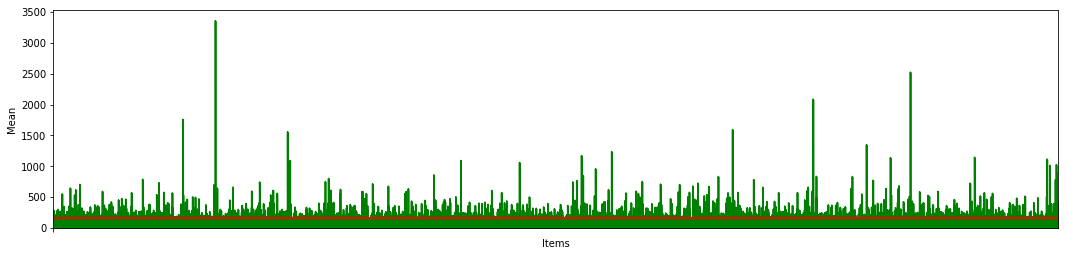

In [38]:
dmean = lastfm_describe.mean().mean()
outputfile = fig_path + "//mean_bar.png"
plot_with_mean('area', lastfm_describe.mean(), dmean, outputfile, 1000, (18,4), "Items", "Mean")
print("Mean: ", dmean)

Mean of Std. Dev:  371.31721668309615


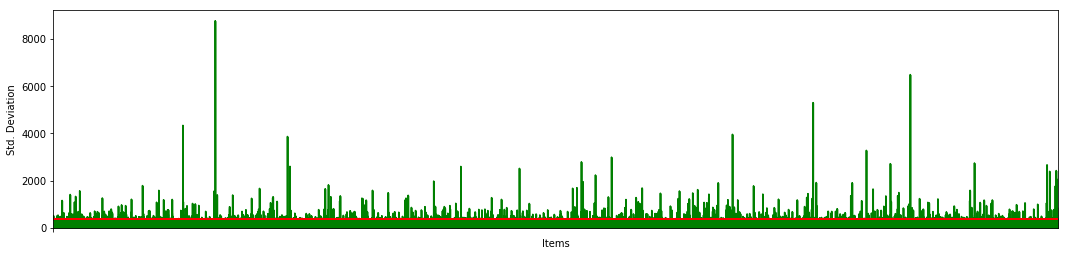

In [39]:
stdmean = lastfm_describe.std().mean()
outputfile = fig_path + "//stdev_bar.png"
plot_with_mean('area', lastfm_describe.std(), stdmean, outputfile, 1000, (18,4), "Items", "Std. Deviation")
print("Mean of Std. Dev: ", stdmean)

In [40]:
lastfm_corr = calculate_correlation(lastfm)

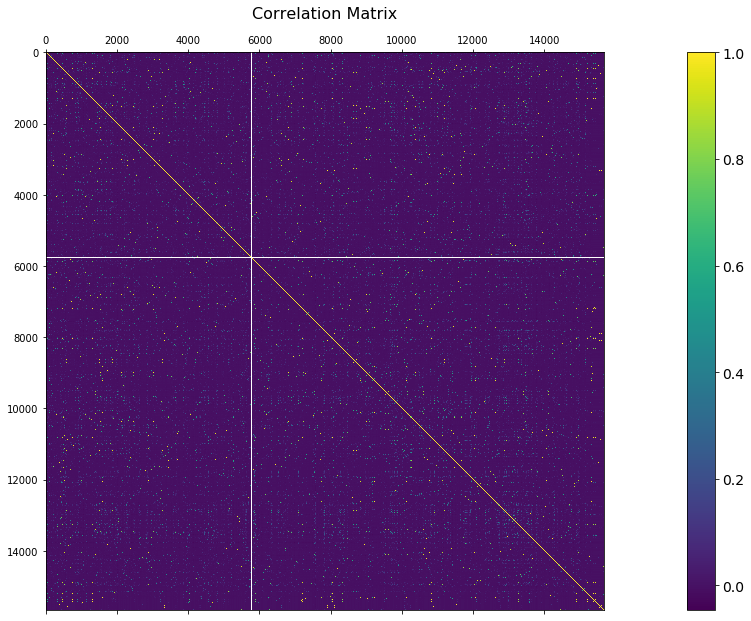

In [41]:
outputfile = fig_path + '//CorrPlot.png'
plot_corr(lastfm, lastfm_corr, outputfile)

user total consumption mean: 14321.40625


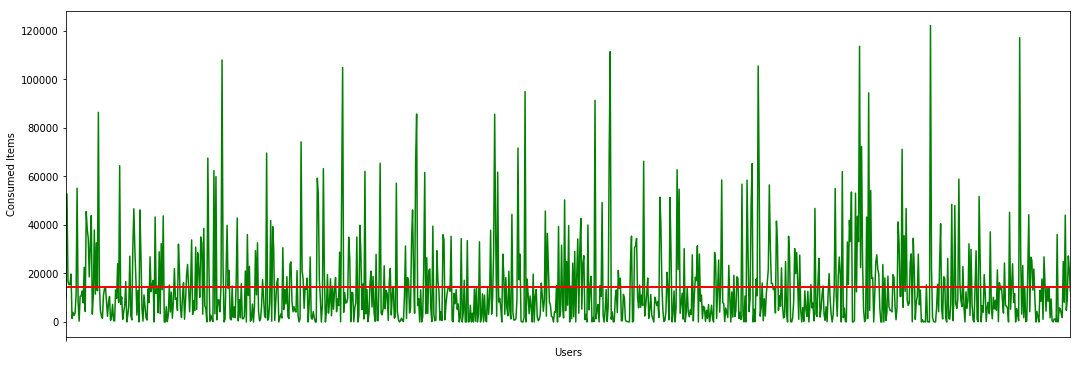

In [42]:
# calculate user total consumption and its mean.
lastfm_tuc, lastfm_tuc_mean  = count_user_consumed_items(lastfm)
print("user total consumption mean:" ,lastfm_tuc_mean[0])
# plot it.
outputfile = fig_path + "//tuc_hist.png"
plot_with_mean('line', lastfm_tuc.iloc[:,0], lastfm_tuc_mean[0], outputfile, 30, (18,6), "Users", "Consumed Items")

Distinct user consumption mean: 505.5625


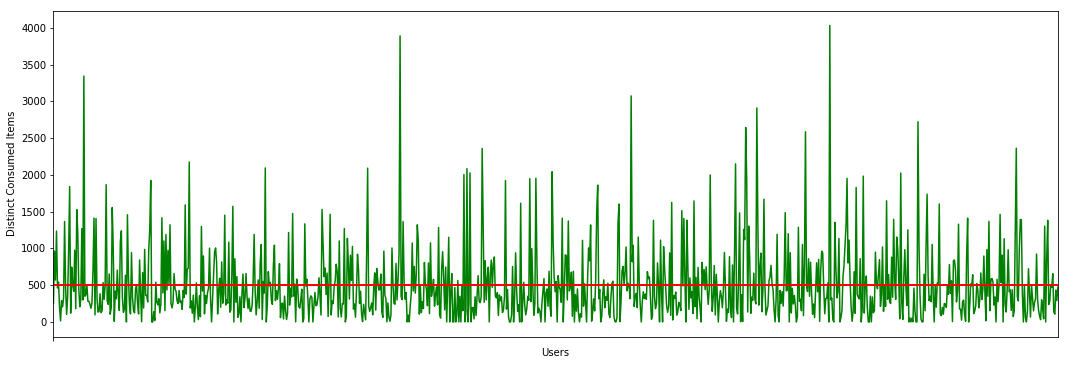

In [43]:
# count average number of distinct consumed items for user and its mean.
lastf_distinct_user_consumption = count_distinct_user_consumption(lastfm)
lastf_distinct_user_consumption_mean = lastf_distinct_user_consumption.mean(0)
print("Distinct user consumption mean:" , lastf_distinct_user_consumption_mean[0])
# plot it.
outputfile = fig_path + "//astf_distinct_consumption_hist.png"
plot_with_mean("line", lastf_distinct_user_consumption.iloc[:,0], lastf_distinct_user_consumption_mean[0], outputfile, 30, (18,6), "Users", "Distinct Consumed Items")

Train dataset Density: 3.2267200663773297%


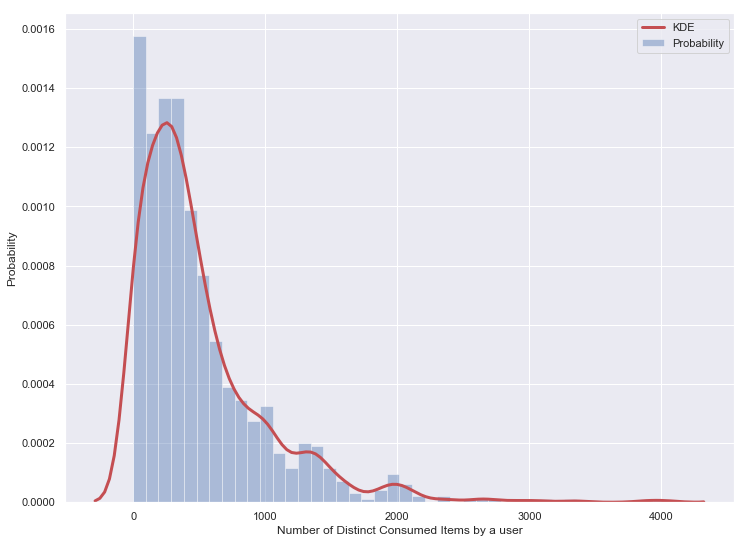

In [44]:
# calculate density.
lastfm_density = calculate_density_value(lastfm)
print("Train dataset Density: " + str(lastfm_density) + "%")

# plot density.
plot_density(lastf_distinct_user_consumption,'Number of Distinct Consumed Items by a user','Probability')

In [45]:
%%time

user_unique_items, user_unique_items_,user_unique_items_average = calculate_user_unique_items(lastfm)

print("Mean number of items consumed by a only user: " , user_unique_items_average)
user_unique_items_percentage = (user_unique_items_.sum()[0]/user_unique_items.sum()[0])*100
print("Percentage of unique items consumed more than one time: " + str(user_unique_items_percentage) + "%")

Mean number of items consumed by a only user:  1.1512096774193548
Percentage of unique items consumed more than one time: 98.77408056042032%
CPU times: user 19min 9s, sys: 3.09 s, total: 19min 12s
Wall time: 19min 12s


In [46]:
%%time
percentage_repeated_consumption = calculate_repeated_consumption(lastfm, lastfm_tuc)
print("Percentage of repeat consumption (Train dataset): " + str(percentage_repeated_consumption) + "%")

Percentage of repeat consumption (Train dataset): 98.91072149426667%
CPU times: user 759 ms, sys: 6.32 ms, total: 765 ms
Wall time: 767 ms


Gini Coefficient of dataset:  0.9945008383328043


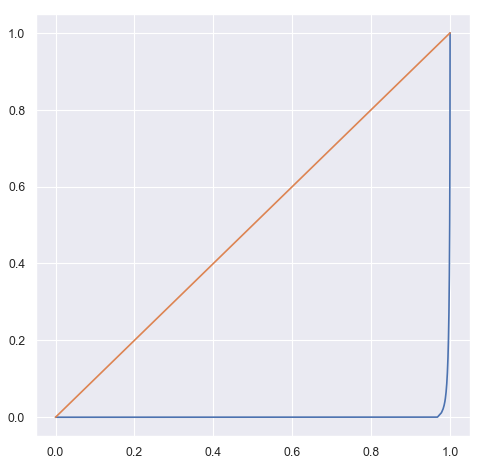

In [47]:
outputfile = fig_path + "//gini_curve.png"
lastfm_gini_coeff = plot_gini_curve(lastfm, (7, 7), outputfile)

print("Gini Coefficient of dataset: ", str(lastfm_gini_coeff))

In [48]:
# number of distinct user that consumes an item
total_item_distinct_consumption, total_item_distinct_consumption_mean, hits = calculate_hits(lastfm)
print("user distinct total consumption mean:" , total_item_distinct_consumption_mean[0])

user distinct total consumption mean: 32.00906305846311


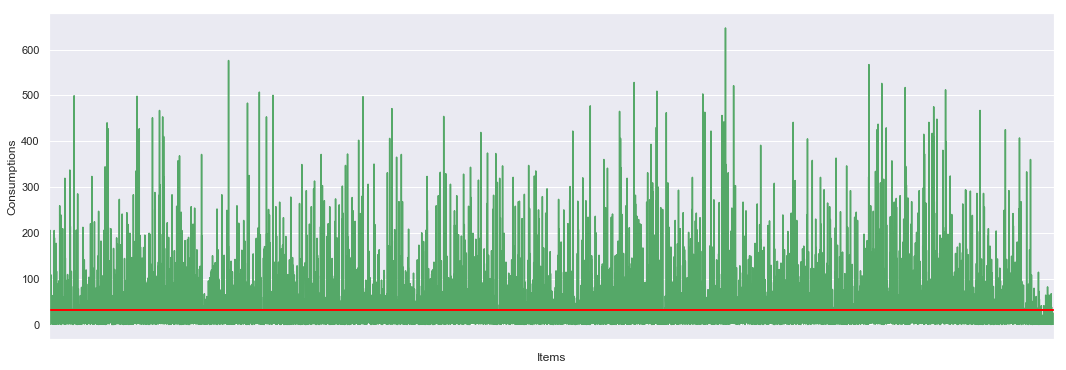

In [49]:
outputfile = fig_path + "//distinct_consumption.png"
plot_with_mean('line', total_item_distinct_consumption.iloc[:,0], total_item_distinct_consumption_mean[0], outputfile, 500, (18,6), "Items", "Consumptions")

## VALIDATION

In [50]:
# open last fm dataset (validation).
filename = to_filename(dataset_name, 'validation')
lastfmval = load_dataset(filename)

Memory usage: 124341328


In [51]:
# normalize the time (3y->3m)
hits_value = hits_value/12 

In [52]:
lastfmval_describe = lastfmval.describe()
lastfmval_describe

0           1           2           3      4           5      \
count  992.000000  992.000000  992.000000  992.000000  992.0  992.000000   
mean     0.020161    0.225806    0.010081    0.182460    0.0    0.006048   
std      0.635001    1.763350    0.317500    2.060139    0.0    0.109874   
min      0.000000    0.000000    0.000000    0.000000    0.0    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.0    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.0    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.0    0.000000   
max     20.000000   35.000000   10.000000   57.000000    0.0    2.000000   

            6      7           8           9      ...       15658       15659  \
count  992.000000  992.0  992.000000  992.000000  ...  992.000000  992.000000   
mean     0.025202    0.0    0.037298    0.055444  ...    0.064516    0.243952   
std      0.580867    0.0    0.661482    0.973903  ...    1.264221    7.620208   
min      0.000000    0.0    0.000000    0.000000  ...    0.000000    0.000000   
25%      0.000000    0.0    0.000000    0.000000  ...    0.000000    0.000000   
50%      0.000000    0.0    0.000000    0.000000  ...    0.000000    0.000000   
75%      0.000000    0.0    0.000000    0.000000  ...    0.000000    0.000000   
max     18.000000    0.0   20.000000   26.000000  ...   33.000000  240.000000   

            15660  15661  15662  15663       15664  15665       15666  15667  
count  992.000000  992.0  992.0  992.0  992.000000  992.0  992.000000  992.0  
mean     0.072581    0.0    0.0    0.0    0.160282    0.0    0.001008    0.0  
std      1.424442    0.0    0.0    0.0    4.922150    0.0    0.031750    0.0  
min      0.000000    0.0    0.0    0.0    0.000000    0.0    0.000000    0.0  
25%      0.000000    0.0    0.0    0.0    0.000000    0.0    0.000000    0.0  
50%      0.000000    0.0    0.0    0.0    0.000000    0.0    0.000000    0.0  
75%      0.000000    0.0    0.0    0.0    0.000000    0.0    0.000000    0.0  
max     40.000000    0.0    0.0    0.0  155.000000    0.0    1.000000    0.0  

[8 rows x 15668 columns]

In [53]:
lastfmval_corr = calculate_correlation(lastfmval)

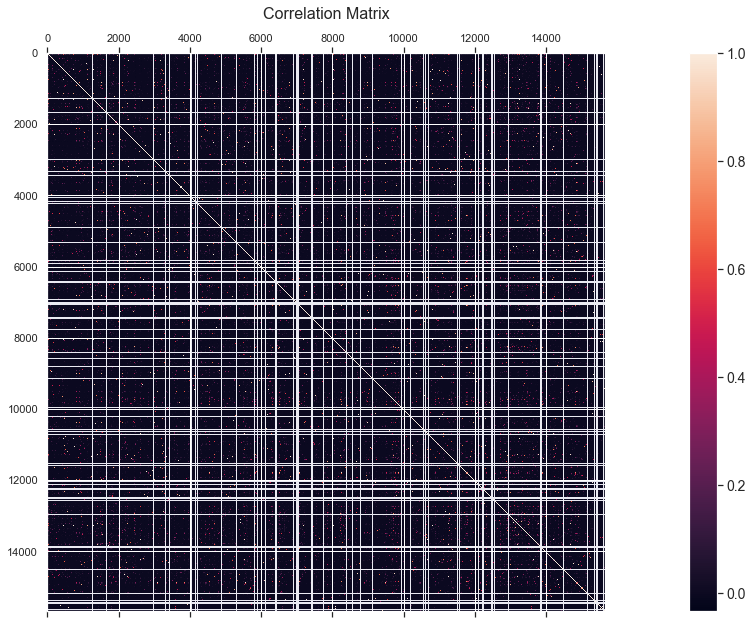

In [54]:
outputfile = fig_path + '//val_CorrPlot.png'
plot_corr(lastfmval, lastfmval_corr, outputfile)

user total consumption mean: 1593.5020161290322


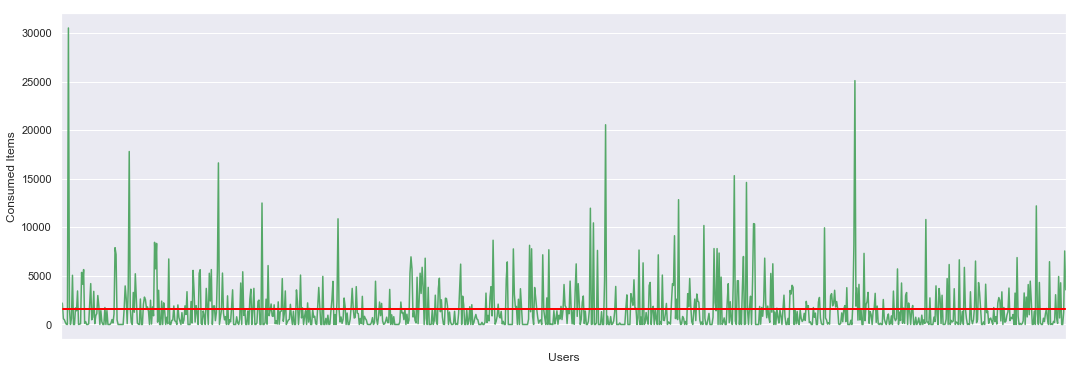

In [55]:
# calculate user total consumption and its mean.
lastfmval_tuc, lastfmval_tuc_mean  = count_user_consumed_items(lastfmval)
print("user total consumption mean:" ,lastfmval_tuc_mean[0])
# plot it.
outputfile = fig_path + "//val_tuc_hist.png"
plot_with_mean('line', lastfmval_tuc.iloc[:,0], lastfmval_tuc_mean[0], outputfile, 30, (18,6),"Users", "Consumed Items")

user distinct total consumption mean: 153.39717741935485


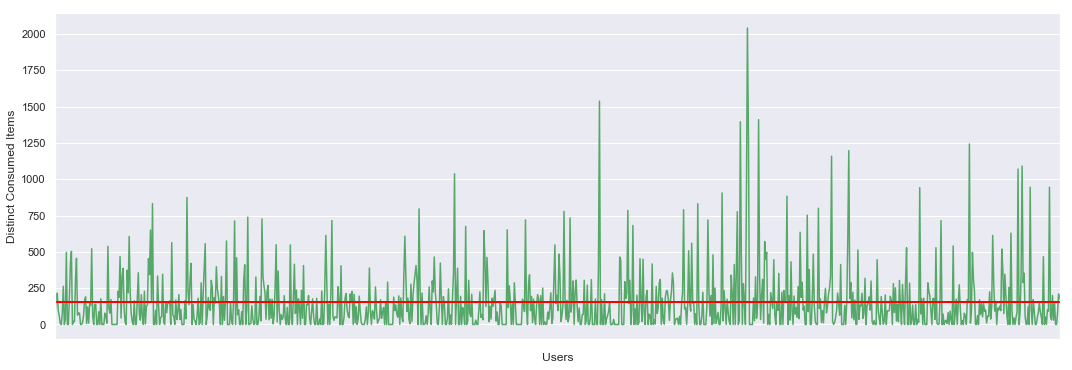

In [56]:
# count average number of distinct consumed items for user and its mean.
lastfval_distinct_consumption = count_distinct_user_consumption(lastfmval)
lastfval_distinct_consumption_mean = lastfval_distinct_consumption.mean(0)
print("user distinct total consumption mean:" , lastfval_distinct_consumption_mean[0])
# plot it.
outputfile = fig_path + "//val_astf_distinct_consumption_hist.png"
plot_with_mean('line',lastfval_distinct_consumption.iloc[:,0], lastfval_distinct_consumption_mean[0], outputfile, 30, (18,6),"Users", "Distinct Consumed Items")

Train dataset Density: 0.9790475964983076%


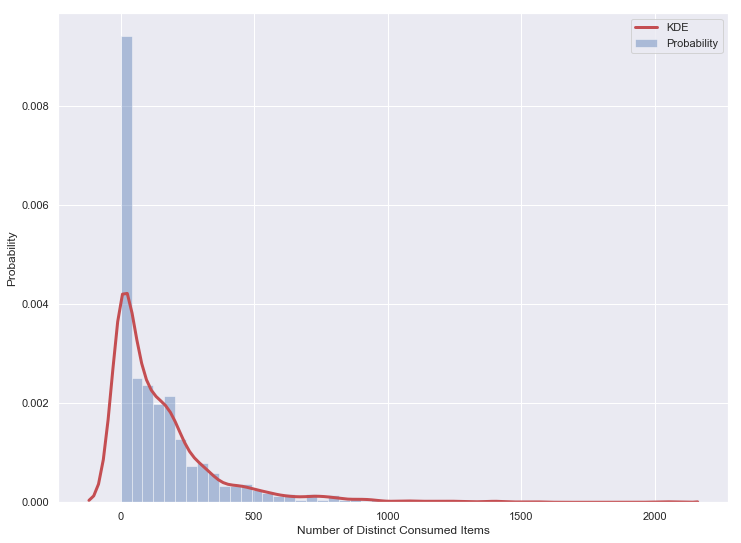

In [57]:
# calculate density.
lastfmval_density = calculate_density_value(lastfmval)
print("Train dataset Density: " + str(lastfmval_density) + "%")

# plot density.
plot_density(lastfval_distinct_consumption,'Number of Distinct Consumed Items','Probability')

In [59]:
%%time
val_user_unique_items, val_user_unique_items_, val_user_unique_items_average = calculate_user_unique_items(lastfmval)

print("Mean number of items consumed by a only user: " , val_user_unique_items_average)
val_user_unique_items_percentage = (val_user_unique_items_.sum()[0]/val_user_unique_items.sum()[0])*100
print("Percentage of unique items consumed more than one time: " + str(val_user_unique_items_percentage) + "%")

Mean number of items consumed by a only user:  2.5534274193548385
Percentage of unique items consumed more than one time: 78.08922226608765%
CPU times: user 5min 53s, sys: 972 ms, total: 5min 54s
Wall time: 5min 54s


In [60]:
%%time
val_percentage_repeated_consumption = calculate_repeated_consumption(lastfmval, lastfmval_tuc)
print("Percentage of repeat consumption (Validation dataset): " + str(val_percentage_repeated_consumption) + "%")

Percentage of repeat consumption (Validation dataset): 96.38362452348689%
CPU times: user 662 ms, sys: 3.25 ms, total: 665 ms
Wall time: 664 ms


Gini Coefficient of validation dataset:  0.9975884805447094


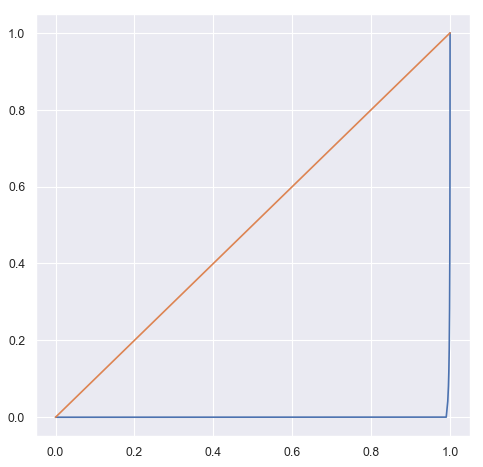

In [61]:
outputfile = fig_path + "//val_gini_curve.png"
lastfmval_gini_coeff = plot_gini_curve(lastfmval, (7, 7), outputfile)

print("Gini Coefficient of validation dataset: ", str(lastfmval_gini_coeff))

In [62]:
# number of distinct user that consumes an item
val_total_item_distinct_consumption, val_total_item_distinct_consumption_mean, val_hits = calculate_hits(lastfmval)
print("user distinct total consumption mean:" , val_total_item_distinct_consumption_mean[0])

user distinct total consumption mean: 9.712152157263212


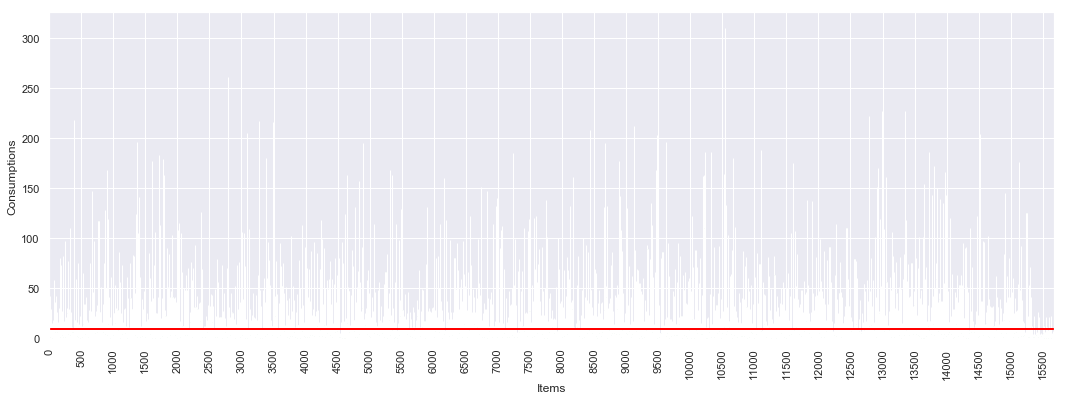

In [63]:
outputfile = fig_path + "//val_distinct_consumption.png"
plot_with_mean('bar',val_total_item_distinct_consumption.iloc[:,0], val_total_item_distinct_consumption_mean[0], outputfile, 500, (18,6), "Items", "Consumptions")

In [64]:
old_hits, new_hits, stable_hits = calculate_hits_deltas(hits, val_hits)
# calculate length of hits dicts. 
number_of_hits = len(hits)
number_of_validation_hits = len(val_hits)
number_of_new_hits = len(new_hits)
number_of_old_hits = len(old_hits)
number_of_stable_hits = len(stable_hits)

print("Number of hits (train dataset): " + str(number_of_hits))
print("Number of hits (validation dataset): " + str(number_of_validation_hits))
print("Number of new hits: " + str(number_of_new_hits))
print("Number of old hits: " + str(number_of_old_hits))
print("Number of stable hits: " + str(number_of_stable_hits))

# calculate percentage of new hits inside validation set.
percentage_of_new_hits = (number_of_new_hits/number_of_validation_hits)*100

# calculate percentage of old hits inside TRAIN set.
percentage_of_old_hits = (number_of_old_hits/number_of_hits)*100

# calculate percentage of stable hits inside validation set.
percentage_of_stable_hits = (number_of_stable_hits/number_of_validation_hits)*100


print("\nPercentage of new hits: " + str(percentage_of_new_hits) + "%")
print("Percentage of old hits: " + str(percentage_of_old_hits) + "%")
print("Percentage of stable hits: " + str(percentage_of_stable_hits) + "%")

Number of hits (train dataset): 1122
Number of hits (validation dataset): 4352
Number of new hits: 3230
Number of old hits: 0
Number of stable hits: 1122

Percentage of new hits: 74.21875%
Percentage of old hits: 0.0%
Percentage of stable hits: 25.78125%


In [65]:
# calculate exploration rate.
exploration_rate, exploration_rate_mean, user_distinct_exploration = calculate_exploration_rate(lastfm, lastfmval, lastfmval_tuc)
print("Exploration rate (validation dataset): " + str(exploration_rate_mean) + "%")

Exploration rate (validation dataset): 19.249033548320842%


In [66]:
# calculate exploration rate related to the item distinct consumption.
distinct_exploration_rate = {}       
distinct_exploration_rate_mean = 0

for i in range(len(user_distinct_exploration)):
    # we divide the exploration consumed item for the total consumption.
    distinct_exploration_rate[i] = (user_distinct_exploration[i]/lastfmval_tuc.iloc[i][0])*100

# remove nan values and make the mean.
distinct_exploration_rate_mean = np.nan_to_num(np.array(list(distinct_exploration_rate.values()))).mean()
print("Distinct exploration rate (validation dataset): " + str(distinct_exploration_rate_mean) + "%")

Distinct exploration rate (validation dataset): 5.48144855162409%


# TEST

### MEANSHIFT CLUSTERING

In [ ]:
%%time

lastfmT = lastfm.T
elements_to_cluster=len(lastfmT)

labels, labels_unique, n_clusters, cluster_centers = MeanShiftCluster(lastfmT, elements_to_cluster)

print("Number of clusters:", n_clusters)

In [56]:
cluster = [ ] 

# for each color and number of cluster.
for k in range(n_clusters):
    # if we have the k element is a label
    # segna a True gli indici del dataset che appartengono al cluster "k"
    my_members = labels == k
    # save cluster center k.
    cluster_center = cluster_centers[k]
    # seleziona colore
    mycolor = matplotlib.colors.colorConverter.to_rgb(matplotlib.pyplot.cm.Spectral(float(k) / n_clusters, 1))
    mycolor ='rgb'+str(mycolor)

    row = lastfmT.iloc[:elements_to_cluster].values[my_members, 3]
    col = lastfmT.iloc[:elements_to_cluster].values[my_members, 4]
        
    #plot cluster.
    trace = go.Scatter(x=lastfmT.iloc[:elements_to_cluster].values[my_members, 3], 
                       y=lastfmT.iloc[:elements_to_cluster].values[my_members, 4], 
                       mode='markers', showlegend=False, name='Cluster'+str(k),
                       marker= dict(color=mycolor, size=10,))
    
    # plot cluster center.
    trace1 = go.Scatter(x=[cluster_center[0]], y=[cluster_center[1]], 
                        mode='markers',  showlegend=False,
                        marker=dict(color=mycolor, size=20,
                               line=dict(color = 'black',
                                           width = 1)))
    cluster.append(trace)
    cluster.append(trace1)

In [57]:
silhouette_avg = silhouette_score(lastfmT.iloc[:elements_to_cluster].values, labels)
print("For n_clusters =", n_clusters,", the average silhouette_score is :", silhouette_avg)

For n_clusters = 668 , the average silhouette_score is : 0.393907224125351


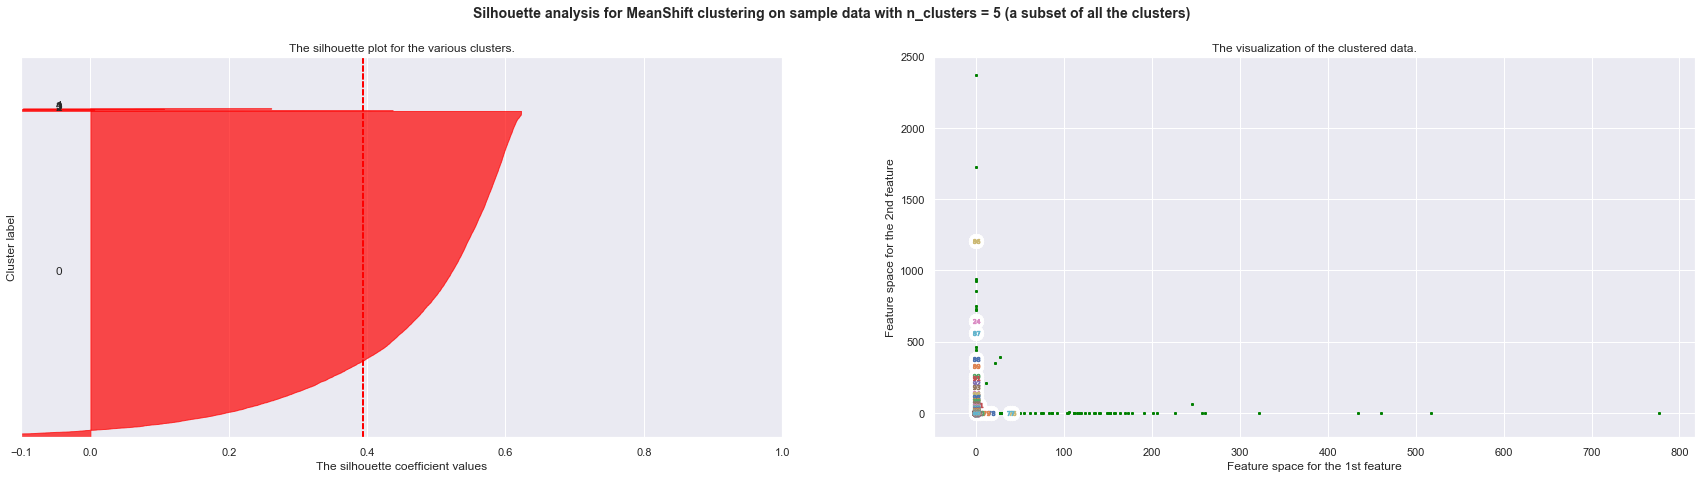

CPU times: user 48.7 s, sys: 1.22 s, total: 49.9 s
Wall time: 37.4 s


In [58]:
%%time
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(lastfmT.iloc[:elements_to_cluster].values, labels)

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(30, 7)

n_clusters = 5

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
#lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(lastfmT) + (n_clusters + 1) * 10])
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # seleziona colore
    #color = matplotlib.colors.colorConverter.to_rgb(matplotlib.pyplot.cm.Spectral(float(i) / n_clusters, 1))
    #color ='rgb'+str(color)
    color = 'red'
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    #colors = cm.spectral(labels.astype(float) / n_clusters)
    colors='green'
    ax2.scatter(lastfmT.iloc[:, 0], lastfmT.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Draw white circles at cluster centers
    ax2.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(cluster_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for MeanShift clustering on sample data "
                  "with n_clusters = %d (a subset of all the clusters)" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.savefig("silhouette_" +str(i))
plt.show()

### K-MEANS CLUSTERING

For n_clusters = 2 The average silhouette_score is : 0.9781332884438728


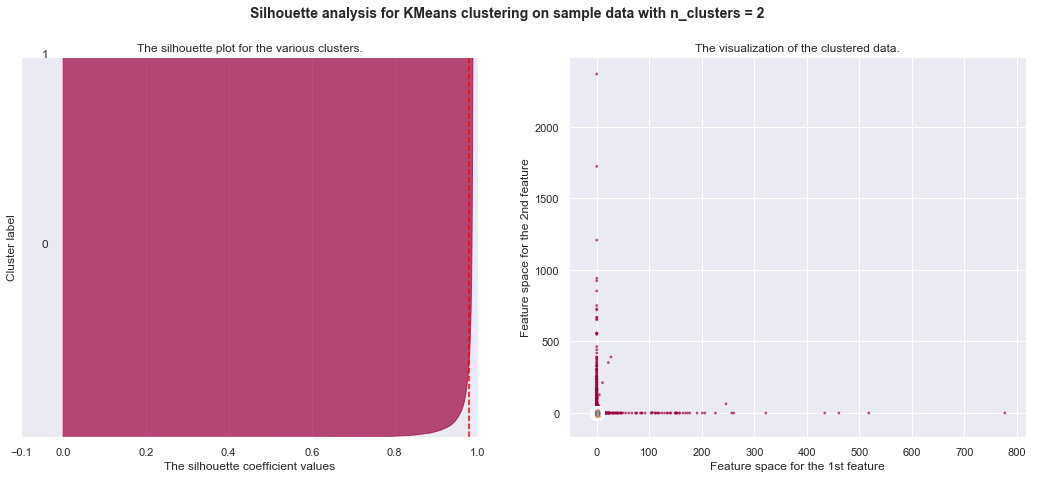

For n_clusters = 10 The average silhouette_score is : 0.8731078324688037


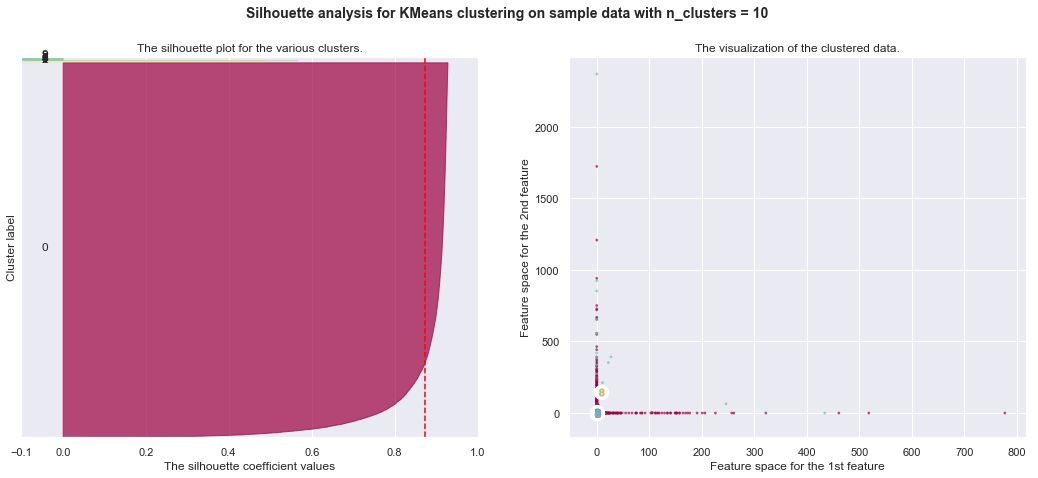

For n_clusters = 20 The average silhouette_score is : 0.8463024562359569


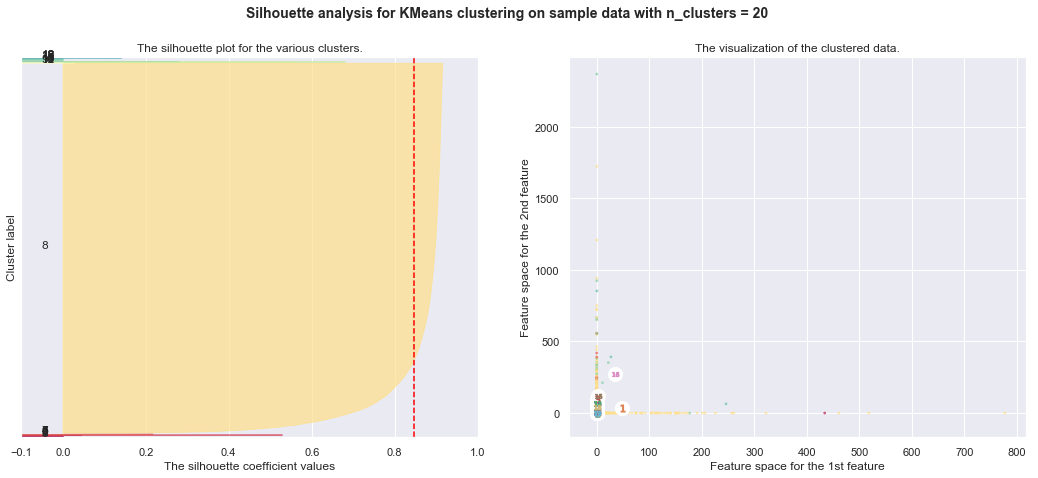

For n_clusters = 50 The average silhouette_score is : 0.7448888535577324


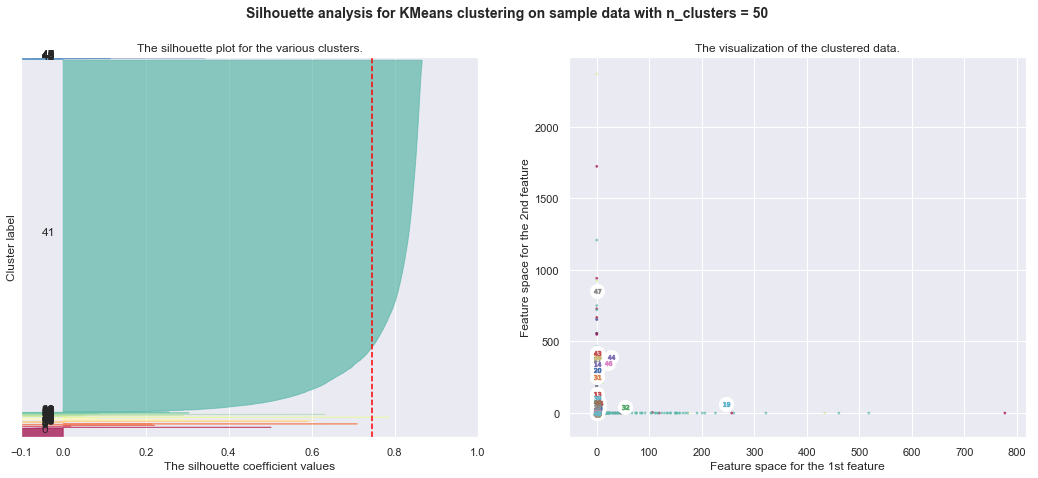

CPU times: user 4min 20s, sys: 10.1 s, total: 4min 30s
Wall time: 1min 32s


In [59]:
%%time
range_n_clusters = [2, 10, 20, 50]

clusterAndPlot(lastfmT, range_n_clusters)

### Using NMF with Clustering

In [60]:
%%time
## Try to use NMF for clustering (feature selection)
model = NMF(n_components = 50, init='random', random_state=0, verbose=False)
W = model.fit_transform(lastfm)
H = model.components_

CPU times: user 1min 3s, sys: 944 ms, total: 1min 4s
Wall time: 16.8 s


For n_clusters = 2 The average silhouette_score is : 0.9788992448520196


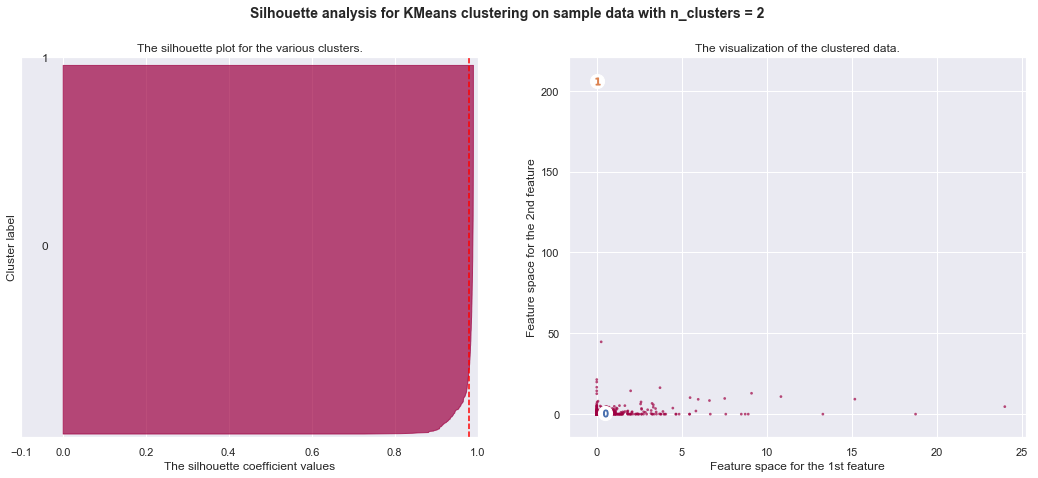

For n_clusters = 3 The average silhouette_score is : 0.7868706891996171


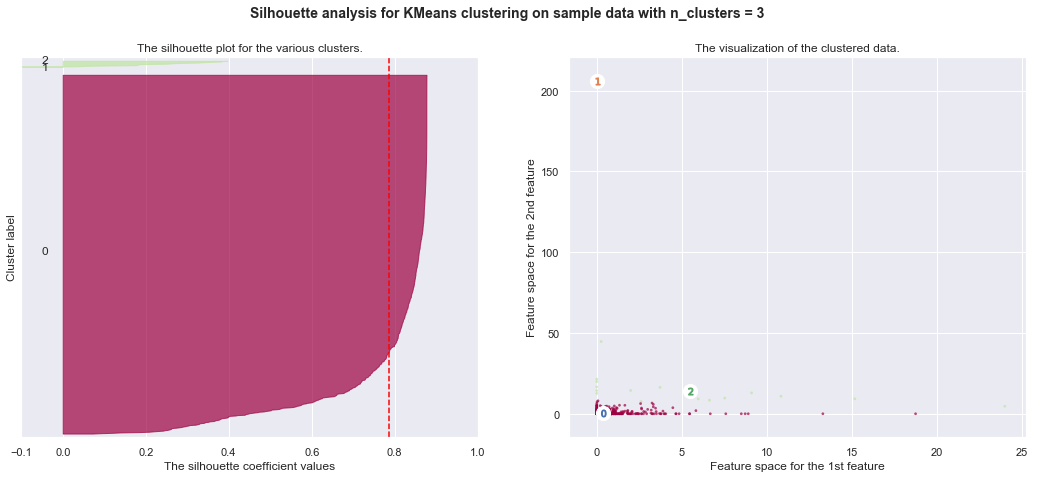

For n_clusters = 4 The average silhouette_score is : 0.7935455544989647


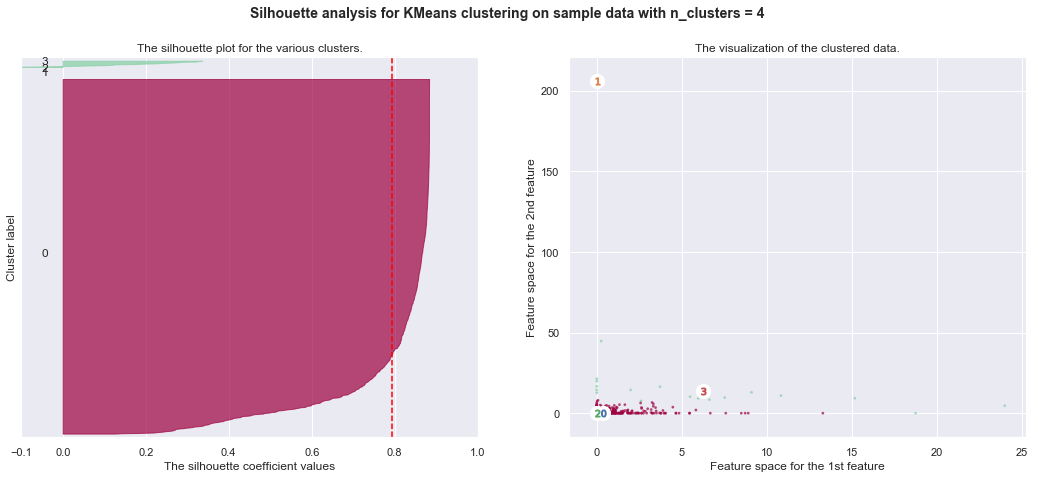

For n_clusters = 5 The average silhouette_score is : 0.7154204501252166


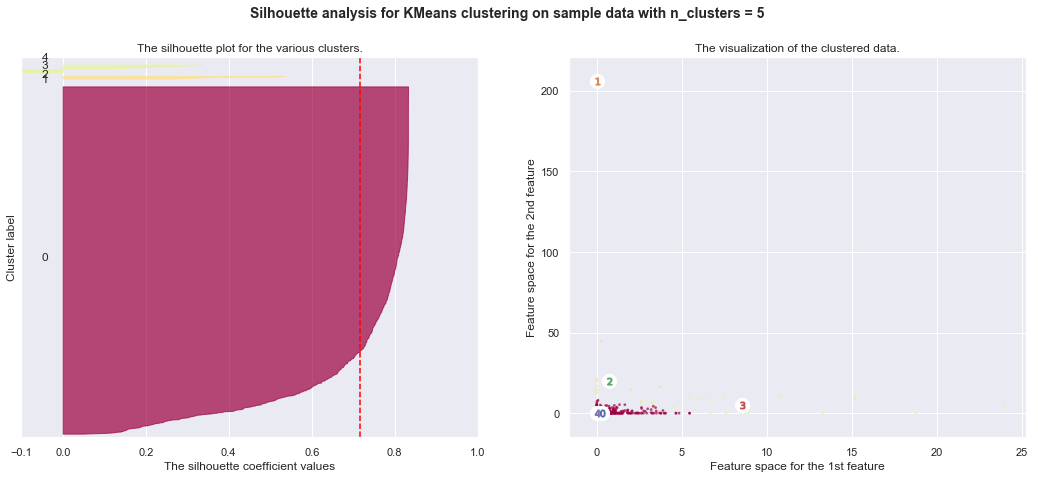

For n_clusters = 10 The average silhouette_score is : 0.46716381561719134


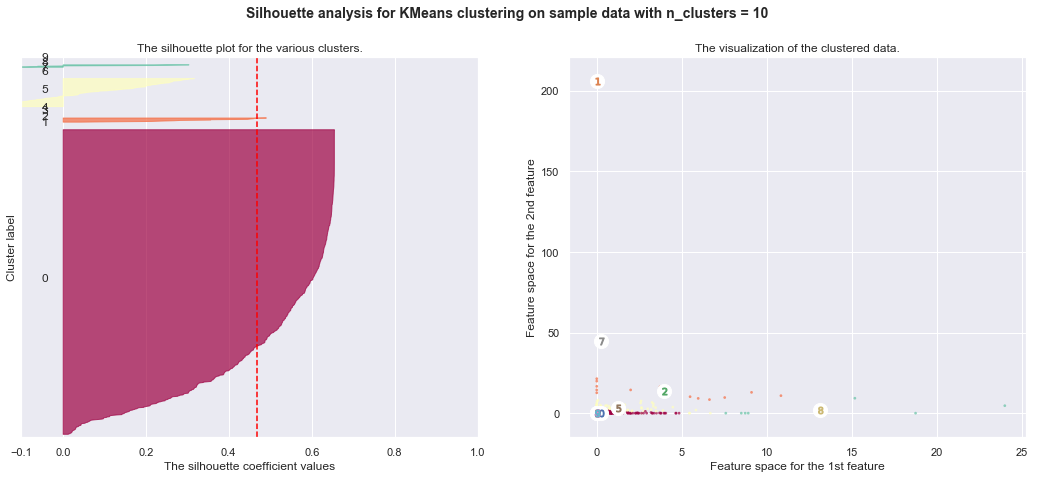

For n_clusters = 20 The average silhouette_score is : 0.5138244228121196


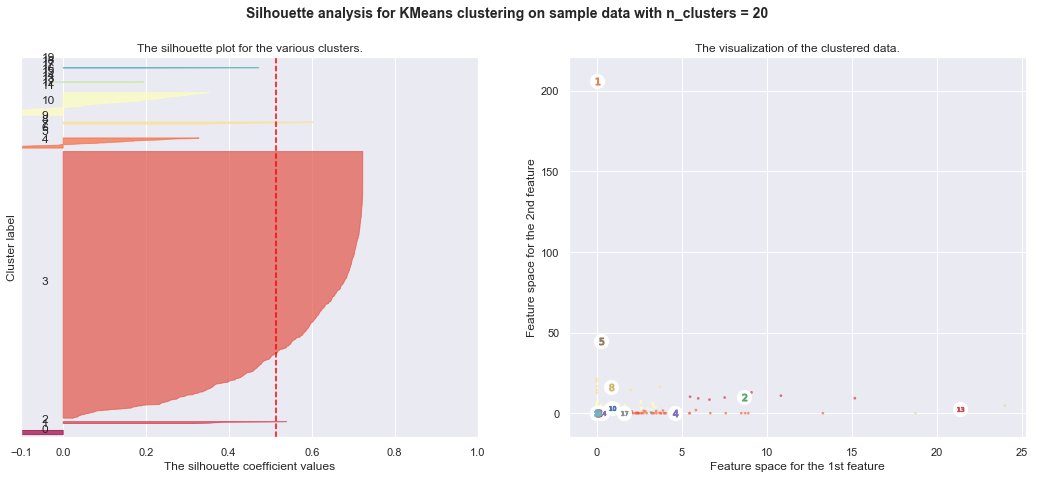

For n_clusters = 50 The average silhouette_score is : 0.4024856926140503


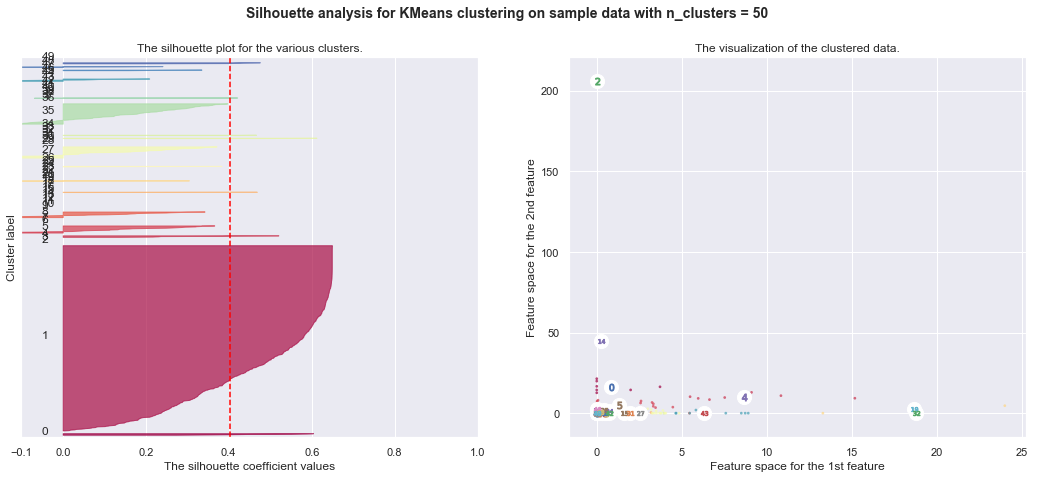

CPU times: user 6.61 s, sys: 179 ms, total: 6.79 s
Wall time: 3.51 s


In [61]:
%%time
range_n_clusters = [2, 3, 4, 5, 10, 20, 50]
clusterAndPlot(pd.DataFrame(W),range_n_clusters)

### MPL with one Hot Encoding

In [62]:
%%time
# converting dataset into string dataset.
lastfm_s = lastfm.astype(str)

CPU times: user 8.32 s, sys: 360 ms, total: 8.68 s
Wall time: 8.69 s


In [63]:
%%time
lastfmval_s = lastfmval.astype(str)

CPU times: user 8.2 s, sys: 314 ms, total: 8.51 s
Wall time: 8.51 s


In [68]:
%%time
# One Hot Encoding
lastfm_one_hot = pd.get_dummies(lastfm_s)
len(lastfm_one_hot.iloc[0])

CPU times: user 23.8 s, sys: 360 ms, total: 24.2 s
Wall time: 24.2 s


In [69]:
%%time
lastfmval_one_hot = pd.get_dummies(lastfmval_s)
len(lastfm_one_hot.iloc[0])

CPU times: user 23.1 s, sys: 254 ms, total: 23.3 s
Wall time: 23.4 s


In [70]:
# Use 15% of the samples as test
X_train, X_test, Y_train, Y_test = train_test_split(lastfm_one_hot, lastfmval_one_hot, test_size=0.15)

In [71]:
# Multi-Layer Perceptron Classifier model.
hidden_layers = (100,100,100)
print("Creating MLP classifier so formed: " + str(hidden_layers) + " with max_iter=500")
print(" ")
mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, verbose=True, max_iter=500)

Creating MLP classifier so formed: (100, 100, 100) with max_iter=500
 


In [72]:
%%time
# fit the model.
print("Start to fit the model")
print(" ")
mlp.fit(X_train, Y_train) 

Start to fit the model
 
Iteration 1, loss = 34586.46093149
Iteration 2, loss = 3349.04555833
Iteration 3, loss = 5107.21458858
Iteration 4, loss = 4832.94308812
Iteration 5, loss = 3855.52619451
Iteration 6, loss = 2927.22920220
Iteration 7, loss = 2257.49808219
Iteration 8, loss = 1913.06238366
Iteration 9, loss = 1767.21087189
Iteration 10, loss = 1716.72144870
Iteration 11, loss = 1683.59404281
Iteration 12, loss = 1668.38660803
Iteration 13, loss = 1656.41379019
Iteration 14, loss = 1641.61749602
Iteration 15, loss = 1628.48498071
Iteration 16, loss = 1612.66993366
Iteration 17, loss = 1596.97569449
Iteration 18, loss = 1581.97590450
Iteration 19, loss = 1566.23069437
Iteration 20, loss = 1553.65119196
Iteration 21, loss = 1539.56539090
Iteration 22, loss = 1525.98600016
Iteration 23, loss = 1519.68980747
Iteration 24, loss = 1504.93048406
Iteration 25, loss = 1493.68670795
Iteration 26, loss = 1481.59648918
Iteration 27, loss = 1469.09196351
Iteration 28, loss = 1455.24278563
Ite

Iteration 236, loss = 303.96947981
Iteration 237, loss = 301.98836032
Iteration 238, loss = 300.48201753
Iteration 239, loss = 299.76792034
Iteration 240, loss = 309.23295885
Iteration 241, loss = 306.39251939
Iteration 242, loss = 300.34043016
Iteration 243, loss = 296.99370234
Iteration 244, loss = 295.55074333
Iteration 245, loss = 297.87052285
Iteration 246, loss = 297.82844590
Iteration 247, loss = 325.06606601
Iteration 248, loss = 313.87250172
Iteration 249, loss = 307.41637766
Iteration 250, loss = 298.85085796
Iteration 251, loss = 298.69040219
Iteration 252, loss = 291.10276337
Iteration 253, loss = 285.54521943
Iteration 254, loss = 283.27266304
Iteration 255, loss = 279.84569149
Iteration 256, loss = 287.39487173
Iteration 257, loss = 287.12905691
Iteration 258, loss = 283.57624808
Iteration 259, loss = 276.90104375
Iteration 260, loss = 280.91071400
Iteration 261, loss = 273.73548717
Iteration 262, loss = 281.97370000
Iteration 263, loss = 281.79814956
Iteration 264, loss 

In [74]:
# make predictions.
print("Start make predictions")
print(" ")
y_pred = mlp.predict(X_test)

# we report its score (in terms of 0/1 Loss and Accuracy Score)-
print("0/1 Loss: " + str(zero_one_loss(Y_test, y_pred)))
print(" ")
print("Accuracy Score: " + str(accuracy_score(Y_test, y_pred)))
print(" ")

y_pred_prob = mlp.predict_proba(X_test)
print(y_pred_prob)

Start make predictions
 
0/1 Loss: 0.8657718120805369
 
Accuracy Score: 0.1342281879194631
 
[[1.00000000e+00 7.15872126e-14 9.82473658e-01 ... 9.99999985e-01
  4.92085308e-09 1.00000000e+00]
 [1.00000000e+00 9.29745687e-12 9.55738863e-01 ... 9.99999072e-01
  2.77454301e-07 1.00000000e+00]
 [1.00000000e+00 2.08564254e-10 9.52444491e-01 ... 9.99996081e-01
  1.40980762e-06 1.00000000e+00]
 ...
 [1.00000000e+00 7.04622227e-19 9.97415042e-01 ... 1.00000000e+00
  2.36270786e-13 1.00000000e+00]
 [1.00000000e+00 1.77740728e-34 9.99980733e-01 ... 1.00000000e+00
  1.41743248e-29 1.00000000e+00]
 [1.00000000e+00 1.23505265e-11 9.60051957e-01 ... 9.99999826e-01
  5.48479600e-08 1.00000000e+00]]


### MLP

In [75]:
# open last fm dataset (test).
filename = to_filename(dataset_name, 'test')
lastfmtest = load_dataset(filename)

Memory usage: 124341328


In [76]:
# Multi-Layer Perceptron Classifier model.
hidden_layers = (1000,1000,1000)
print("Creating MLP classifier so formed: " + str(hidden_layers) + " with max_iter=500")
print(" ")
mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, verbose=True, max_iter=500)

Creating MLP classifier so formed: (1000, 1000, 1000) with max_iter=500
 


In [82]:
%%time
val = {}

#foreach row.
for i, row in lastfm.iterrows():
    val[i] = 0
    max_value = 0
    j = 0
    for item in row:
        if(item >  max_value):
            # i is the row index.
            val[i] = j
            max_value = item
        j += 1

#conversion.
val = pd.DataFrame.from_dict(val, orient='index' ,columns=['y'])

CPU times: user 3.75 s, sys: 9.6 ms, total: 3.76 s
Wall time: 3.76 s


In [86]:
%%time
val_val = {}

#foreach row.
for i, row in lastfmval.iterrows():
    val_val[i] = 0
    max_value = 0
    j = 0
    for item in row:
        if(item >  max_value):
            # i is the row index.
            val_val[i] = j
            max_value = item

        j += 1
    
val_val = pd.DataFrame.from_dict(val_val, orient='index' ,columns=['y'])

CPU times: user 3.58 s, sys: 3.95 ms, total: 3.58 s
Wall time: 3.58 s


In [87]:
%%time
val_test = {}

#foreach row.
for i, row in lastfmtest.iterrows():
    val_test[i] = 0
    max_value = 0
    j = 0
    for item in row:
        if(item >  max_value):
            # i is the row index.
            val_test[i] = j
            max_value = item

        j += 1
    
val_test = pd.DataFrame.from_dict(val_test, orient='index' ,columns=['y'])

CPU times: user 3.6 s, sys: 4.25 ms, total: 3.6 s
Wall time: 3.61 s


In [85]:
%%time
# fit the model.
print("Start to fit the model")
print(" ")
mlp.fit(lastfm, val)

Start to fit the model
 


/Users/andreaperelli/.conda/envs/DA2019/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Iteration 1, loss = 23.93144708
Iteration 2, loss = 6.20861269
Iteration 3, loss = 2.62431894
Iteration 4, loss = 2.06055186
Iteration 5, loss = 1.74383112
Iteration 6, loss = 1.51900156
Iteration 7, loss = 1.34351254
Iteration 8, loss = 1.20498379
Iteration 9, loss = 1.08697097
Iteration 10, loss = 0.98726573
Iteration 11, loss = 0.89541791
Iteration 12, loss = 0.80746209
Iteration 13, loss = 0.71265035
Iteration 14, loss = 0.64163399
Iteration 15, loss = 0.56011746
Iteration 16, loss = 0.45089095
Iteration 17, loss = 0.42152557
Iteration 18, loss = 0.40612326
Iteration 19, loss = 0.37865258
Iteration 20, loss = 0.40862424
Iteration 21, loss = 0.33682693
Iteration 22, loss = 0.35620133
Iteration 23, loss = 0.37653514
Iteration 24, loss = 0.31626289
Iteration 25, loss = 0.28241264
Iteration 26, loss = 0.26438363
Iteration 27, loss = 0.26365465
Iteration 28, loss = 0.28308338
Iteration 29, loss = 0.31000267
Iteration 30, loss = 0.41470017
Iteration 31, loss = 0.21470314
Iteration 32, lo

In [89]:
# make predictions
print(" ")
print("Start make predictions")
print(" ")
y_pred = mlp.predict(lastfmval)

# we report its score (in terms of 0/1 Loss and Accuracy Score)
print("0/1 Loss: " + str(zero_one_loss(val_val, y_pred)))
print(" ")
print("Accuracy Score: " + str(accuracy_score(val_val, y_pred)))
print(" ")

predict_prob_m = mlp.predict_proba(lastfmval)
print(predict_prob_m)

 
Start make predictions
 
0/1 Loss: 0.6491935483870968
 
Accuracy Score: 0.35080645161290325
 
[[1.70516811e-15 1.07891504e-06 1.87206164e-16 ... 4.66353380e-05
  1.16512163e-07 5.00490978e-06]
 [1.11946427e-09 1.68874448e-03 2.18961444e-09 ... 3.15812014e-04
  2.14092473e-04 4.70876283e-03]
 [7.47378913e-05 2.53538140e-03 2.50338758e-04 ... 2.47866314e-03
  1.15935205e-03 1.56778228e-03]
 ...
 [6.52063280e-22 1.34948724e-07 9.95031389e-12 ... 3.79532329e-08
  1.43015853e-07 9.85870268e-07]
 [1.20248634e-34 1.92510416e-10 4.20073180e-35 ... 1.29663777e-12
  1.17816800e-13 1.07969644e-11]
 [3.29577931e-30 1.71060309e-11 1.06421933e-23 ... 3.75344385e-13
  1.22886171e-13 2.71630139e-12]]


In [90]:
# calculate test dataset hits.
total_item_distinct_consumption, total_item_distinct_consumption_mean, test_hits = calculate_hits(lastfmval)

In [91]:
# take first five hits.
first_five = [0,0,0,0,0]
first_five_indexes = [0,0,0,0,0]

i = 0
#foreach index.
for hit_i in test_hits:
        
    # if the hit is greater than min_hit.
    if(test_hits[hit_i] > first_five[0]):
                
        first_five[0] = test_hits[hit_i]
        first_five_indexes[0] = hit_i
        
        if(test_hits[hit_i] > first_five[1]):
            
            first_five[0], first_five[1] = first_five[1], first_five[0]
            first_five_indexes[0], first_five_indexes[1] = first_five_indexes[1], first_five_indexes[0]

            if(test_hits[hit_i] > first_five[2]):
                
                first_five[1], first_five[2] = first_five[2], first_five[1]
                first_five_indexes[1], first_five_indexes[2] = first_five_indexes[2], first_five_indexes[1]

                
                if(test_hits[hit_i] > first_five[3]):
                        
                    first_five[2], first_five[3] = first_five[3], first_five[2]
                    first_five_indexes[2], first_five_indexes[3] = first_five_indexes[3], first_five_indexes[2]

                    if(test_hits[hit_i] > first_five[4]):
                                   
                        first_five[3], first_five[4] = first_five[4], first_five[3]
                        first_five_indexes[3], first_five_indexes[4] = first_five_indexes[4], first_five_indexes[3]

first_five, first_five_indexes       

([222, 227, 227, 261, 310], [12786, 13351, 12986, 2797, 10548])

In [92]:
# number of CHOSEN items that are consumed (by the single user) in the test set.
consumed = 0
# number of CHOSEN items that are consumed (by the single user) in the test set more than 10 times.
consumed10 = 0

#foreach row inside test set..
for i, row in lastfmtest.iterrows():
    
    # take feature index.
    index = y_pred[i]
    
    # if the feature was consumed.
    if(row[index] > 0):
        
        consumed +=1
        
        # if the feature was consumed more than 10 times.
        if(row[index] >= 10):
            consumed10 += 1
    
    # was not consumed.
    else:
        
        ok = False

        # check it were consumed.
        for hit_index in first_five_indexes:
            
            
            if(ok== True):
                # exit: we won't count more than one time an hit.
                break
            
            if(row[hit_index] > 0):
                consumed +=1
                
                ok = True
                
                if(row[hit_index] >= 10):
                    consumed10 +=1
    
print("Accuracy with hit help: " + str(consumed/len(lastfm)) + "%")
print("Accuracy with hit help for a consume >= 10:" + str(consumed10/len(lastfm))+ "%")

Accuracy with hit help: 0.49899193548387094%
Accuracy with hit help for a consume >= 10:0.25201612903225806%
